In [1]:
print(__doc__)
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Automatically created module for IPython interactive environment


In [2]:
dataset_read = pd.read_excel("dataset.xlsx")
dataset = dataset_read.iloc[:,0:4]
training_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"]
test_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Te"]

In [3]:
# from sklearn.model_selection import train_test_split
# dataset_read = pd.read_excel("dataset.xlsx")
# dataset = dataset_read.iloc[:,0:4]
# training_set, test_set = train_test_split(dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"], test_size=0.5)
# training_set.head(3)

In [4]:
fpSize=4096
xytuple = namedtuple('xytuple', ['x', 'y'])
def df_to_xy(df):
    ### return numpy of arrays
    # Make an arr of lipophillicity values
    lip_arr = df['experimental logD7.4'].values
    # Make an arr of fingerprints
    mol_series = df['SMILES structure'].apply(Chem.MolFromSmiles)
    RDK_fp_series = mol_series.apply(lambda mol: np.array(RDKFingerprint(mol, fpSize=fpSize)))
    RDK_fp_arr = np.matrix(RDK_fp_series.tolist())
    return xytuple(x=RDK_fp_arr, y=lip_arr)

In [5]:
### Prepare training set and test set to feed into ml algo
X_train, y_train = df_to_xy(training_set)
X_test, y_test = df_to_xy(test_set)

In [10]:
## Data normalization/scaling
from sklearn.preprocessing import Normalizer, MinMaxScaler

total_df = np.concatenate((X_train,X_test))
lip = np.concatenate((y_train,y_test))

std_scale = MinMaxScaler().fit(total_df)
X_train_sc = std_scale.transform(X_train)
X_test_sc  = std_scale.transform(X_test)
total_df_s = std_scale.transform(total_df)
n_scale = Normalizer().fit(total_df_s)
X_train_n = n_scale.transform(X_train_sc)
X_test_n  = n_scale.transform(X_test_sc)


enviorment_data = namedtuple('enviorment_data', ['X_train', 'y_train', 'X_test', 'y_test'])
env = enviorment_data(X_train=X_train_n, y_train=None, X_test=X_test_n, y_test=None)

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
X = env.X_train
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

X = env.X_test
X_r1 = pca.transform(X)

pd.DataFrame(X_r, columns=['PC1','PC2']).head()

,PC1,PC2
0,0.028378,-0.026511
1,-0.066069,0.028514
2,0.804169,0.048275
3,-0.020718,-0.035580
4,0.720158,0.042210


In [12]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.05715731 0.04784566]


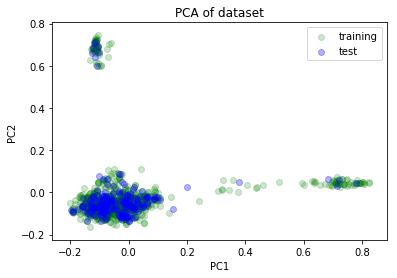

In [13]:
# Gime us an image that can help us visualize how similar each molecule is to each other, 
# as well as how similar the training set is to the test set
plt.figure()
lw = 1

plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.2, lw=lw, color='green', label='training')
plt.scatter(X_r1[:, 0], X_r1[:, 1], alpha=.3, lw=lw, color='blue', label='test')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of dataset')

plt.show()